<h1>Feature analysis - machine learning, Q1</h1>

<b>Imports</b>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('https://www.inf.ed.ac.uk/teaching/courses/fds/data/project-2022-2023/airbnb/listings.csv.gz')

In [3]:
edinburgh = data[['host_is_superhost', 'host_listings_count', 'host_total_listings_count', 
                  'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_cleansed',
                  'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'latitude', 'longitude',
                  'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_nights_avg_ntm',
                  'maximum_nights_avg_ntm', 'has_availability', 'availability_30', 'availability_60', 'availability_90',
                  'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
                  'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                  'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable',
                  'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
                  'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms',
                  'reviews_per_month']]

In [4]:
# Remove column with accomodates value 0
edinburgh = edinburgh[edinburgh.accommodates != 0]

# Remove any duplicates
edinburgh.drop_duplicates()

# Drop entries that are not a 'short-term rental'
edinburgh = edinburgh.drop(index=edinburgh[edinburgh['minimum_nights'] > 30].index)

# Bathroom column fixed
edinburgh['bathrooms_text'] = edinburgh['bathrooms_text'].str.extract(r'([\d.]+)').astype('float')

# Drop NaN and reindex
edinburgh = edinburgh.dropna()
edinburgh = edinburgh.reset_index(drop=True)

In [5]:
# Fixing the price column
edinburgh["price"] = edinburgh["price"].replace('[$,]', '', regex=True).astype(float)

copy = edinburgh.copy()
copy['price'] = copy['price'].astype(int)

# Standardise price
edinburgh['price_per_person'] = edinburgh['price'] / edinburgh['accommodates']

# Removing outliers
# Quartiles by the Empirical Rule
low = 0.025
high = 0.975
dfDropped1 = edinburgh.quantile([low, high])

# Empirical Rule
low = dfDropped1['price_per_person'][low]
high = dfDropped1['price_per_person'][high]

# Remove outliers in the dataframe to include only two standard deviations
edinburgh = edinburgh[edinburgh['price_per_person']>=low]
edinburgh = edinburgh[edinburgh['price_per_person']<=high]

edinburgh = edinburgh.drop('price_per_person', axis=1)

edinburgh['log_price'] = np.log10(edinburgh['price'])

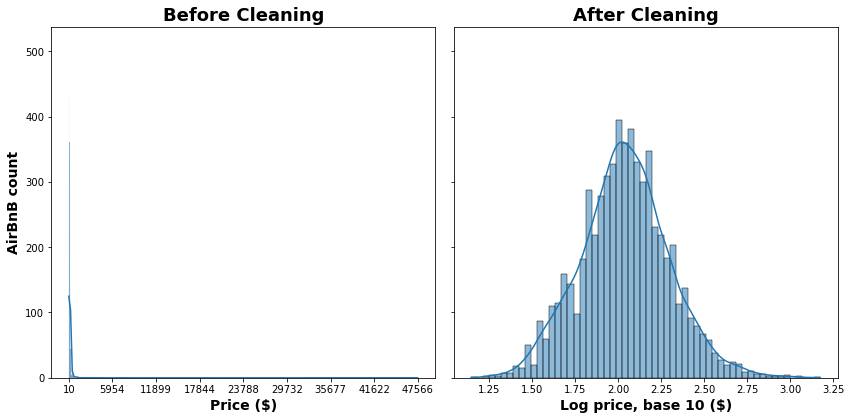

In [6]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)

sns.histplot(copy['price'], kde=True, ax=axs[0])
axs[0].set_title("Before Cleaning", fontdict={'fontsize': 18, 'fontweight': 'bold'})
axs[0].set_xticks(np.linspace(copy['price'].min(), copy['price'].max(), 9))
axs[0].set_xlabel("Price ($)", fontdict={'fontsize': 14, 'fontweight': 'bold'})
axs[0].set_ylabel("AirBnB count", fontdict={'fontsize': 14, 'fontweight': 'bold'})

sns.histplot(edinburgh["log_price"], kde=True, ax=axs[1])
axs[1].set_title("After Cleaning", fontdict={'fontsize': 18, 'fontweight': 'bold'})
axs[1].set_xlabel("Log price, base 10 ($)", fontdict={'fontsize': 14, 'fontweight': 'bold'})
axs[1].set_ylabel("AirBnB count", fontdict={'fontsize': 14, 'fontweight': 'bold'})
sns.set_theme()
plt.tight_layout()
plt.savefig("Cleaning_visual.png")
plt.show()

In [7]:
edinburgh = edinburgh.drop('price', axis=1)
# edinburgh = edinburgh.rename({'calculated_host_listings_count': 'host_listings_count'})
# edinburgh = edinburgh.rename({'calculated_host_listings_count_private_rooms': 'host_count_private_rooms'})
# edinburgh = edinburgh.rename({'calculated_host_listings_count_entire_homes': 'host_count_entire_homes'})
# edinburgh = edinburgh.rename({'calculated_host_listings_count_shared_rooms': 'host_count_shared_rooms'})

# edinburgh = edinburgh.rename(columns={'calculated_host_listings_count': 'host_listings_count', 'calculated_host_listings_count_private_rooms': 'host_count_private_rooms', 'calculated_host_listings_count_entire_homes': 'host_count_entire_homes', 'calculated_host_listings_count_shared_rooms': 'host_count_shared_rooms'})

In [8]:
# corrM = edinburgh.corr()
# plt.figure(figsize=(15,10))
# corrM.drop("log_price").loc[:, "log_price"].sort_values().plot(kind="barh")
# plt.tight_layout()
# plt.savefig("correlation.png")
# plt.yticks(fontsize='14.5')
# sns.set_theme()

# plt.show()

In [9]:
edinburgh['amenities'] = edinburgh['amenities'].str.lower()
selfCheck = [False]*edinburgh.shape[0]
kitchen = selfCheck.copy()
bath = selfCheck.copy()
wifi = selfCheck.copy()
heating = selfCheck.copy()
hairDry = selfCheck.copy()
tv = selfCheck.copy()
parking = selfCheck.copy()

for i in range(edinburgh.shape[0]):
    looking = edinburgh.iloc[i]
    tempAmen = looking['amenities']
    tempAmen = tempAmen.replace('"', '')
    tempAmen = tempAmen.replace('[', '')
    tempAmen = tempAmen.replace(']', '')
    tempAmen = tempAmen.split(', ')
    for j in tempAmen:
        if 'self check' in j:
            selfCheck[i] = True
        if 'kitchen' in j:
            kitchen[i] = True
        if 'bath' in j:
            bath[i] = True
        if 'wifi' in j:
            wifi[i] = True
        if 'heating' in j:
            heating[i] = True
        if ('hairdry' in j) or ('hair dry' in j):
            hairDry[i] = True
        if 'tv' in j:
            tv[i] = True
        if 'parking' in j:
            parking[i] = True

edinburgh = edinburgh.drop(['amenities'], axis=1)
edinburgh['selfCheckIn'] = np.array(selfCheck).astype(int)
edinburgh['kitchen'] = np.array(kitchen).astype(int)
edinburgh['heating'] = np.array(heating).astype(int)
edinburgh['wifi'] = np.array(wifi).astype(int)
edinburgh['tv'] = np.array(tv).astype(int)
edinburgh['bathAmen'] = np.array(bath).astype(int)
edinburgh['parking'] = np.array(parking).astype(int)
edinburgh['hairDryer'] = np.array(hairDry).astype(int)

In [10]:
categorical_col = []
for column in edinburgh.columns:
    
    if edinburgh[column].dtypes != "float64" and edinburgh[column].dtypes != "int64":
        categorical_col.append(column)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in categorical_col:
    edinburgh[col] = le.fit_transform(edinburgh[col])

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

cols_to_scale = ['host_listings_count', 'host_total_listings_count', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month']

edinburgh[cols_to_scale] = scaler.fit_transform(edinburgh[cols_to_scale])

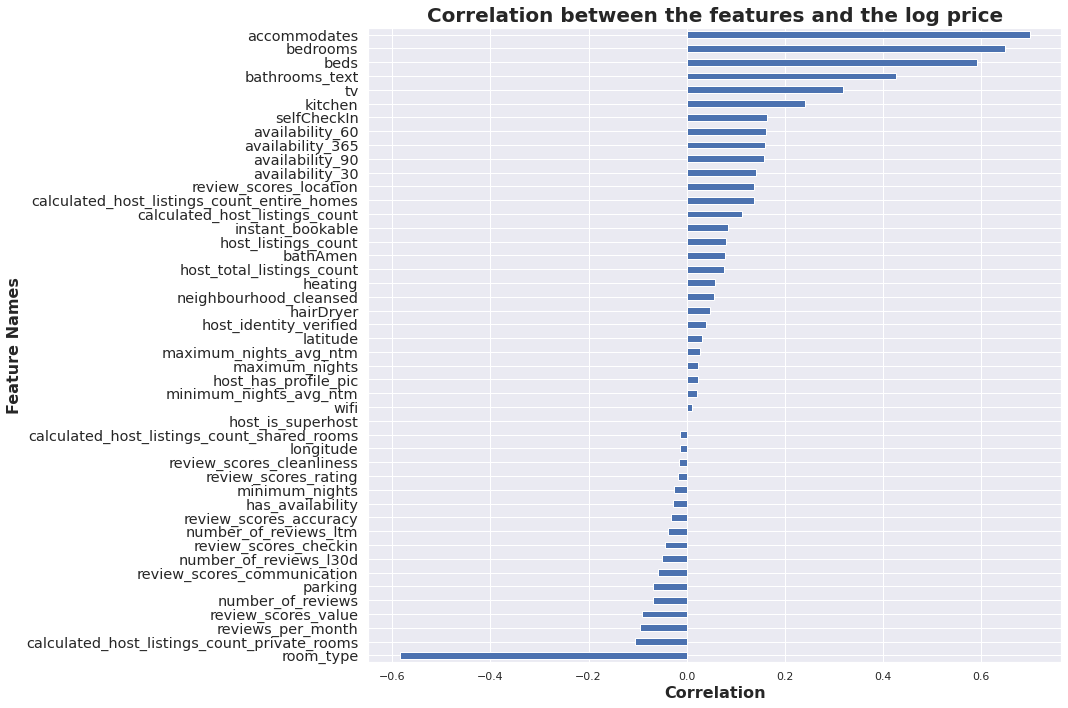

In [12]:
# edinburgh = edinburgh.rename(columns={'calculated_host_listings_count': 'host_listings_count', 'calculated_host_listings_count_private_rooms': 'host_count_private_rooms', 'calculated_host_listings_count_entire_homes': 'host_count_entire_homes', 'calculated_host_listings_count_shared_rooms': 'host_count_shared_rooms'})

corrM = edinburgh.corr()
plt.figure(figsize=(15,10))
corrM.drop("log_price").loc[:, "log_price"].sort_values().plot(kind="barh")
plt.yticks(fontsize='14.5')
sns.set_theme()
plt.title("Correlation between the features and the log price", fontdict={'fontsize': 20, 'fontweight': 'bold'})
plt.xlabel("Correlation", fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.ylabel("Feature Names", fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.tight_layout()
plt.savefig("correlation.png")
plt.show()

In [13]:
y = edinburgh['log_price']
X = edinburgh.drop('log_price', axis=1)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

n = len(y)
p = X.shape[1]

<b>MLR</b>

In [14]:
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

mlr = LinearRegression()
mlr.fit(X_train, y_train)

y_pred = mlr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)

r2_lr = r2_score(y_test, y_pred)
adjusted_lr = 1 - (1 - r2_lr) * (n - 1) / (n - p - 1)

<b>KNN</b>

In [15]:
from sklearn.neighbors import KNeighborsRegressor

k = 3
knn_reg = KNeighborsRegressor(n_neighbors=k)

knn_reg.fit(X_train, y_train)

y_pred = knn_reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse_knr = mean_squared_error(y_test, y_pred)

r2_knr = r2_score(y_test, y_pred)
adjusted_knr = 1 - (1 - r2_knr) * (n - 1) / (n - p - 1)

<b>RF</b>

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

rf = RandomForestRegressor(n_estimators=250, random_state=42)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred)
r2_rf = r2_score(y_test, y_pred)
adjusted_rf = 1 - (1 - r2_rf) * (n - 1) / (n - p - 1)

importances = rf.feature_importances_

indices = np.argsort(importances)[::-1]

feature_names_rf = [X.columns[idx] for idx in indices]
feature_importances_rf = [importances[idx] for idx in indices]

<b>XGBoost</b>

In [17]:
import sys
!{sys.executable} -m pip install xgboost
import xgboost as xgb

xgb = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

mse_xg = mean_squared_error(y_test, y_pred)
r2_xg = r2_score(y_test, y_pred)
adjusted_xg = 1 - (1 - r2_xg) * (n - 1) / (n - p - 1)

importances = xgb.feature_importances_

indices = np.argsort(importances)[::-1]

feature_names_xgb = [X.columns[idx] for idx in indices]
feature_importances_xgb = [importances[idx] for idx in indices]

  Using cached xgboost-1.7.5-py3-none-manylinux2014_x86_64.whl (200.3 MB)


<b>GBR</b>

In [18]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(loss="ls", learning_rate=0.1, n_estimators=100, random_state=42)

gbr.fit(X_train, y_train)

y_pred = gbr.predict(X_test)

mse_gb = mean_squared_error(y_test, y_pred)
r2_gb = r2_score(y_test, y_pred)
adjusted_gb = 1 - (1 - r2_gb) * (n - 1) / (n - p - 1)

importances = gbr.feature_importances_

indices = np.argsort(importances)[::-1]

feature_names_gbr = [X.columns[idx] for idx in indices]
feature_importances_gbr = [importances[idx] for idx in indices]

Feature importance is a metric that measures the relative importance of each feature or input variable in a machine learning model. The importance of a feature indicates how much it contributes to the performance of the model in making predictions.

The feature importance metric is often measured in terms of the fraction of the total reduction in the model's error that is attributable to the feature. The most common way to calculate feature importance in tree-based models (such as Decision Trees, Random Forests, Gradient Boosting Trees, etc.) is the Mean Decrease Impurity (MDI) or Gini importance.

The MDI importance measures the reduction in impurity (Gini index or entropy) achieved by each feature when it is used to split the nodes of the decision trees. The feature importance is then calculated as the fraction of the total reduction in impurity that is achieved by that feature.

In other types of models, such as linear regression or neural networks, feature importance can be measured using the coefficients or weights assigned to each feature. In this case, the feature importance indicates how much the model's prediction changes for a unit change in the feature value.

It's important to note that feature importance should not be used in isolation to make decisions about which features to include in a model or to guide feature engineering. It should be used in conjunction with other methods such as domain knowledge, exploratory data analysis, and model selection techniques to ensure the best performance of the model.

<b>Comparing regressions</b>

In [19]:
info = [['Multiple Linear', mse_lr, adjusted_lr], ['K Neighbors', mse_knr, adjusted_knr], ['Random Forrest', mse_rf, adjusted_rf], ['XGBoosting', mse_xg, adjusted_xg], ['Gradient Boosting', mse_gb, adjusted_gb]]
scores1 = pd.DataFrame(info, columns=['Regression type', 'MSE', 'r^2'])

In [20]:
rf_tup = list(zip(feature_importances_rf, feature_names_rf))
xgb_tup = list(zip(feature_importances_xgb, feature_names_xgb))
gbr_tup = list(zip(feature_importances_gbr, feature_names_gbr))

rf_dict = {'Feature': [t[1] for t in rf_tup], 'Score_rf': [t[0] for t in rf_tup]}
xgb_dict = {'Feature': [t[1] for t in xgb_tup], 'Score_xgb': [t[0] for t in xgb_tup]}
gbr_dict = {'Feature': [t[1] for t in gbr_tup], 'Score_gbr': [t[0] for t in gbr_tup]}

plot_data = pd.DataFrame(rf_dict)
plot_data = plot_data.merge(pd.DataFrame(xgb_dict), on='Feature')
plot_data = plot_data.merge(pd.DataFrame(gbr_dict), on='Feature')

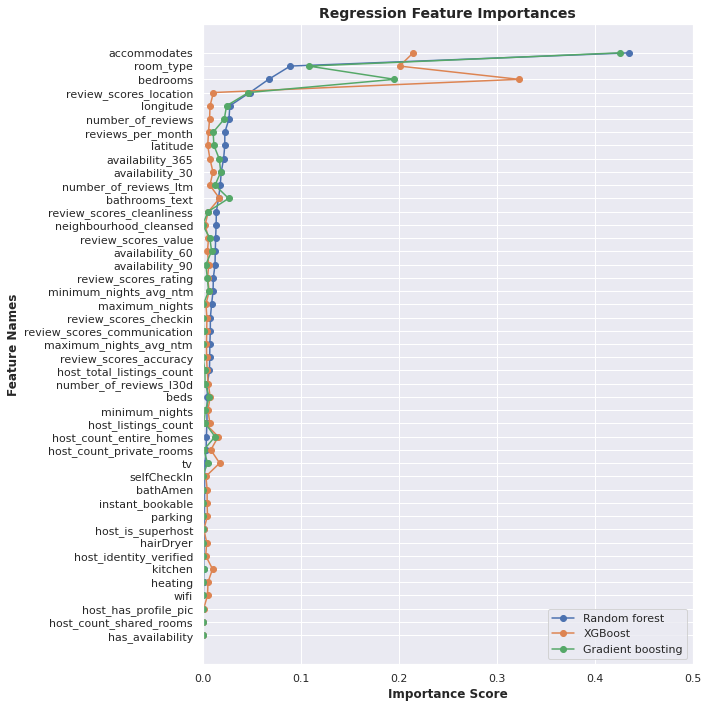

In [21]:
plot_data['Feature'] = plot_data['Feature'].replace({'calculated_host_listings_count': 'host_listings_count'})
plot_data['Feature'] = plot_data['Feature'].replace({'calculated_host_listings_count_private_rooms': 'host_count_private_rooms'})
plot_data['Feature'] = plot_data['Feature'].replace({'calculated_host_listings_count_entire_homes': 'host_count_entire_homes'})
plot_data['Feature'] = plot_data['Feature'].replace({'calculated_host_listings_count_shared_rooms': 'host_count_shared_rooms'})

# Plot the feature importances of the top performing regressions
# Plot the feature importances of the top performing regressions
plt.figure(figsize=(10, 10))
plt.title("Regression Feature Importances", fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.plot(plot_data['Score_rf'], plot_data['Feature'], '-o', label='Random forest')
plt.plot(plot_data['Score_xgb'], plot_data['Feature'], '-o', label='XGBoost')
plt.plot(plot_data['Score_gbr'], plot_data['Feature'], '-o', label='Gradient boosting')
plt.xlabel("Importance Score", fontdict={'fontsize': 12, 'fontweight': 'bold'})
plt.ylabel("Feature Names", fontdict={'fontsize': 12, 'fontweight': 'bold'})
plt.xlim([0,0.5])
# plt.axhline(y=8.5, color='k', linestyle='--')
plt.legend(loc='lower right')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("Regression_FI.png")
plt.show()

<b>PCA rerun</b>

In [22]:
principle_components = ['accommodates', 'bedrooms', 'room_type']
edinburgh.drop('log_price', axis=1)
y = edinburgh['log_price']
X = edinburgh[principle_components]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
n = len(y)
p = X.shape[1]

In [23]:
rf = RandomForestRegressor(n_estimators=250, random_state=42)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mse_rf_2 = mean_squared_error(y_test, y_pred)
r2_rf_2 = r2_score(y_test, y_pred)
adjusted_rf_2 = 1 - (1 - r2_rf_2) * (n - 1) / (n - p - 1)


# import sys
# !{sys.executable} -m pip install xgboost
import xgboost as xgb
from xgboost import XGBRegressor

xgb = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

mse_xg_2 = mean_squared_error(y_test, y_pred)
r2_xg_2 = r2_score(y_test, y_pred)
adjusted_xg_2 = 1 - (1 - r2_xg_2) * (n - 1) / (n - p - 1)

gbr = GradientBoostingRegressor(loss="ls", learning_rate=0.1, n_estimators=100, random_state=42)

gbr.fit(X_train, y_train)

y_pred = gbr.predict(X_test)

mse_gb_2 = mean_squared_error(y_test, y_pred)
r2_gb_2 = r2_score(y_test, y_pred)
adjusted_gb_2 = 1 - (1 - r2_gb_2) * (n - 1) / (n - p - 1)

In [24]:
info2 = [['Random Forrest', mse_rf_2, adjusted_rf_2], ['XGBoosting', mse_xg_2, adjusted_xg_2], ['Gradient Boosting', adjusted_gb_2, r2_gb_2]]
scores2 = pd.DataFrame(info2, columns=['Regression type', 'MSE', 'r^2'])

In [25]:
# Replace missing values with "n/a"
scores2 = scores2.set_index('Regression type')
scores2 = scores2.reindex(scores1['Regression type']).reset_index()
scores2 = scores2.fillna('n/a')

scores = pd.merge(scores1.rename(columns={'MSE': 'MSE before PCA', 'r^2': 'r^2 before PCA'}),
                     scores2.rename(columns={'MSE': 'MSE after PCA', 'r^2': 'r^2 after PCA'}),
                     on='Regression type')

# Define the style for the table
style = (scores.style
         .set_properties(subset=['Regression type'], align='center')
         .set_table_styles([{'selector': 'th:nth-child(1), td:nth-child(1)', 'props': [('text-align', 'left')]},
                            {'selector': 'th:nth-child(2), td:nth-child(2), th:nth-child(4), td:nth-child(4)',
                             'props': [('border-right', '1px solid black')]}])
         .set_caption('Regression Results'))

style

,Regression type,MSE before PCA,r^2 before PCA,MSE after PCA,r^2 after PCA
0,Multiple Linear,0.025559,0.619351,n/a,n/a
1,K Neighbors,0.032881,0.510307,n/a,n/a
2,Random Forrest,0.019429,0.710646,0.027183,0.604938
3,XGBoosting,0.019382,0.711347,0.027402,0.601751
4,Gradient Boosting,0.018959,0.717655,0.607167,0.607358


<h1>Neighbourhood price - geopandas, Q2</h1>

In [27]:
!pip install Basemap
!pip install geopandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
import seaborn as sns
from scipy.stats import skew


data = pd.read_csv('https://www.inf.ed.ac.uk/teaching/courses/fds/data/project-2022-2023/airbnb/listings.csv.gz')

edinburgh = data[['neighbourhood_cleansed', 'price', 'accommodates', 'longitude', 'latitude']]

edinburgh.drop_duplicates()
edinburgh = edinburgh.dropna(axis = 1)
edinburgh = edinburgh.reset_index(drop=True)

zeroentries = (edinburgh == 0).any(axis=1)

edinburgh = edinburgh[~zeroentries]

edinburgh["price"] = edinburgh["price"].replace('[$,]', '', regex=True).astype(float)

edinburgh['price_per_person'] = edinburgh['price'] / edinburgh['accommodates']

skewness = skew(edinburgh['price_per_person'])

low = 0.025
high = 0.975
dfDropped1 = edinburgh.quantile([low, high])

low = dfDropped1['price_per_person'][low]
high = dfDropped1['price_per_person'][high]

edinburgh = edinburgh[edinburgh['price_per_person']>=low]
edinburgh = edinburgh[edinburgh['price_per_person']<=high]

skewness_clean = skew(edinburgh['price_per_person'])

  Using cached basemap-1.3.6-cp39-cp39-manylinux1_x86_64.whl (864 kB)
  Using cached pyshp-2.3.1-py2.py3-none-any.whl (46 kB)
  Using cached pyproj-3.4.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.7 MB)
  Using cached numpy-1.23.5-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Using cached basemap_data-1.3.2-py2.py3-none-any.whl (30.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pointpats 2.2.0 requires opencv-contrib-python>=4.2.0, which is not installed.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.23.5 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.23.5 which is incompatible.
numba 0.55.1 requires numpy<

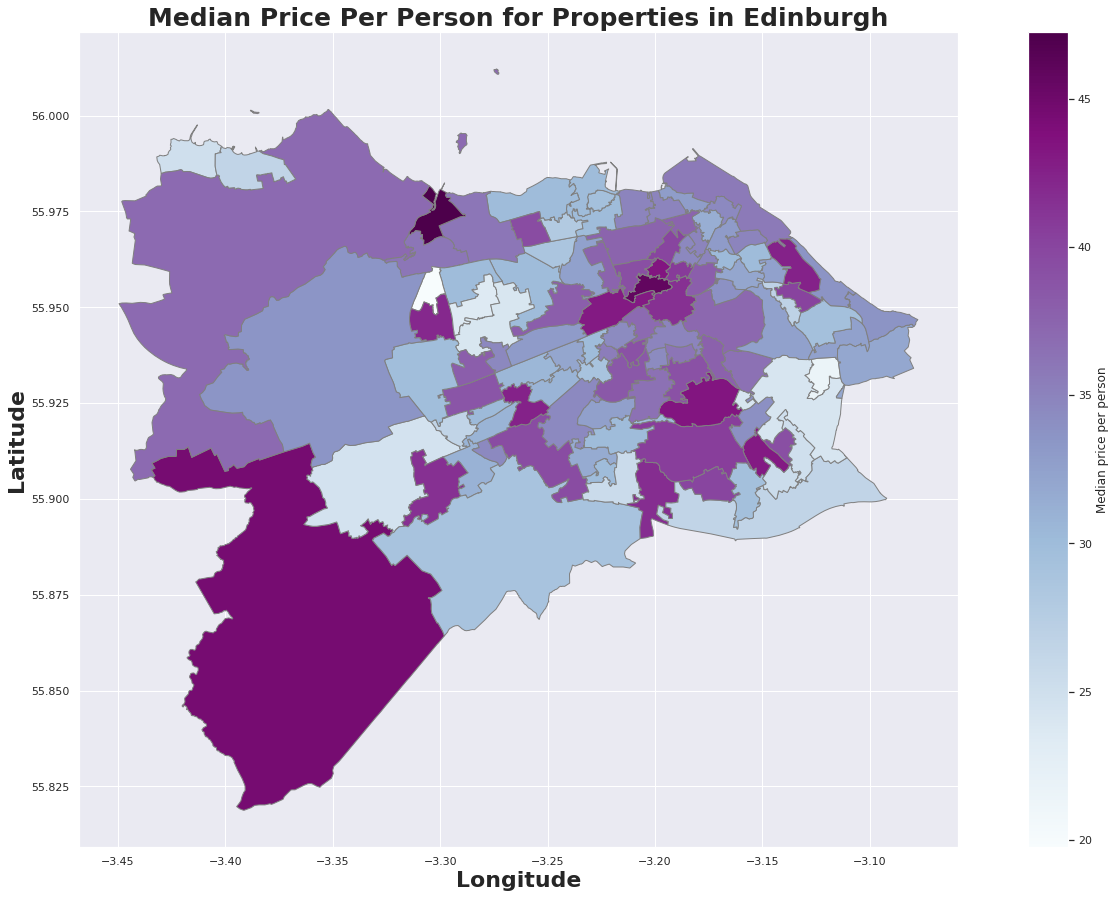

In [28]:
maps = gpd.read_file('https://www.inf.ed.ac.uk/teaching/courses/fds/data/project-2022-2023/airbnb/neighbourhoods.geojson')

maps = maps.rename(columns = {'neighbourhood' : 'neighbourhood_cleansed'})

edinburgh_map = edinburgh.copy(True)
edinburgh_map = edinburgh_map.groupby('neighbourhood_cleansed')['price_per_person'].median().reset_index()
edinburgh_map = maps.merge(edinburgh_map, on='neighbourhood_cleansed', how='left')
edinburgh_map = edinburgh_map.drop(['neighbourhood_group'], axis = 1)

sns.set_theme()

ax = edinburgh_map.plot(column='price_per_person', figsize=(25, 15), cmap='BuPu', edgecolor='grey', 
                         legend=True, legend_kwds={'label': "Median price per person"})

x, y = edinburgh['longitude'].values, edinburgh['latitude'].values
#ax.scatter(x, y, color='red', alpha=0.25, zorder=1, s=5)

#ax = edinburgh_map.apply(lambda x: ax.annotate(text= round(x.price_per_person,1), xy=x.geometry.centroid.coords[0], ha='center', color = "black", fontsize = 8), axis=1)
#ax = edinburgh_map.apply(lambda x: ax.annotate(text= x.neighbourhood_cleansed, xy=x.geometry.centroid.coords[0], ha='center', color = "black", fontsize = 8), axis=1)
plt.xlabel('Longitude', fontsize = 22, weight = 'bold')
plt.ylabel('Latitude', fontsize = 22, weight = 'bold')
plt.title('Median Price Per Person for Properties in Edinburgh', fontsize = 25, weight = 'bold')


# ax.figure.savefig("Edinburgh_map.png")
# ax.figure.savefig("Edinburgh_map_loc.png")
plt.savefig("Edinburgh_map_values.png")
plt.show()

<h1>Price trends comparing summer and winter, Q3</h1>

In [31]:
calendar = pd.read_csv('https://www.inf.ed.ac.uk/teaching/courses/fds/data/project-2022-2023/airbnb/calendar.csv.gz')
calendar["price"] = calendar["price"].replace('[$,]', '', regex=True).astype(float)
calendar["adjusted_price"] = calendar["adjusted_price"].replace('[$,]', '', regex=True).astype(float)
                       
print(calendar.columns)
prices = calendar[['listing_id','date', 'price']]
prices['date'] = pd.to_datetime(prices['date'])

prices = prices.dropna()
prices = prices.reset_index(drop=True)

zeroentries = (prices == 0).any(axis=1)

prices = prices[~zeroentries]

summer_listings = prices[(prices['date']>= '2023-06-21') & (prices['date']<= '2023-09-23')]
skewness_summer = skew(summer_listings['price'])

winter_listings = prices[(prices['date'] >= '2022-12-21') & (prices['date'] <= '2023-03-20')]
skewness_winter = skew(winter_listings['price'])

low_summer = 0.025
high_summer = 0.975
dropped_summer = summer_listings.quantile([low_summer, high_summer])

low_summer = dropped_summer['price'][low_summer]
high_summer = dropped_summer['price'][high_summer]

summer_listings = summer_listings[summer_listings['price']>=low_summer]
summer_listings = summer_listings[summer_listings['price']<=high_summer]
summer_listings = summer_listings.reset_index(drop=True)

skewness_clean_summer = skew(summer_listings['price'])

low_winter = 0.025
high_winter = 0.975
dropped_winter = winter_listings.quantile([low_winter, high_winter])

low_winter = dropped_winter['price'][low_winter]
high_winter = dropped_winter['price'][high_winter]

winter_listings = winter_listings[winter_listings['price']>=low_winter]
winter_listings = winter_listings[winter_listings['price']<=high_winter]
winter_listings = winter_listings.reset_index(drop=True)

skewness_clean_winter = skew(winter_listings['price'])

median_prices = prices.groupby('date')['price'].median()
median_prices_summer = summer_listings.groupby('date')['price'].median()
median_prices_winter = winter_listings.groupby('date')['price'].median()

Index(['listing_id', 'date', 'available', 'price', 'adjusted_price',
       'minimum_nights', 'maximum_nights'],
      dtype='object')


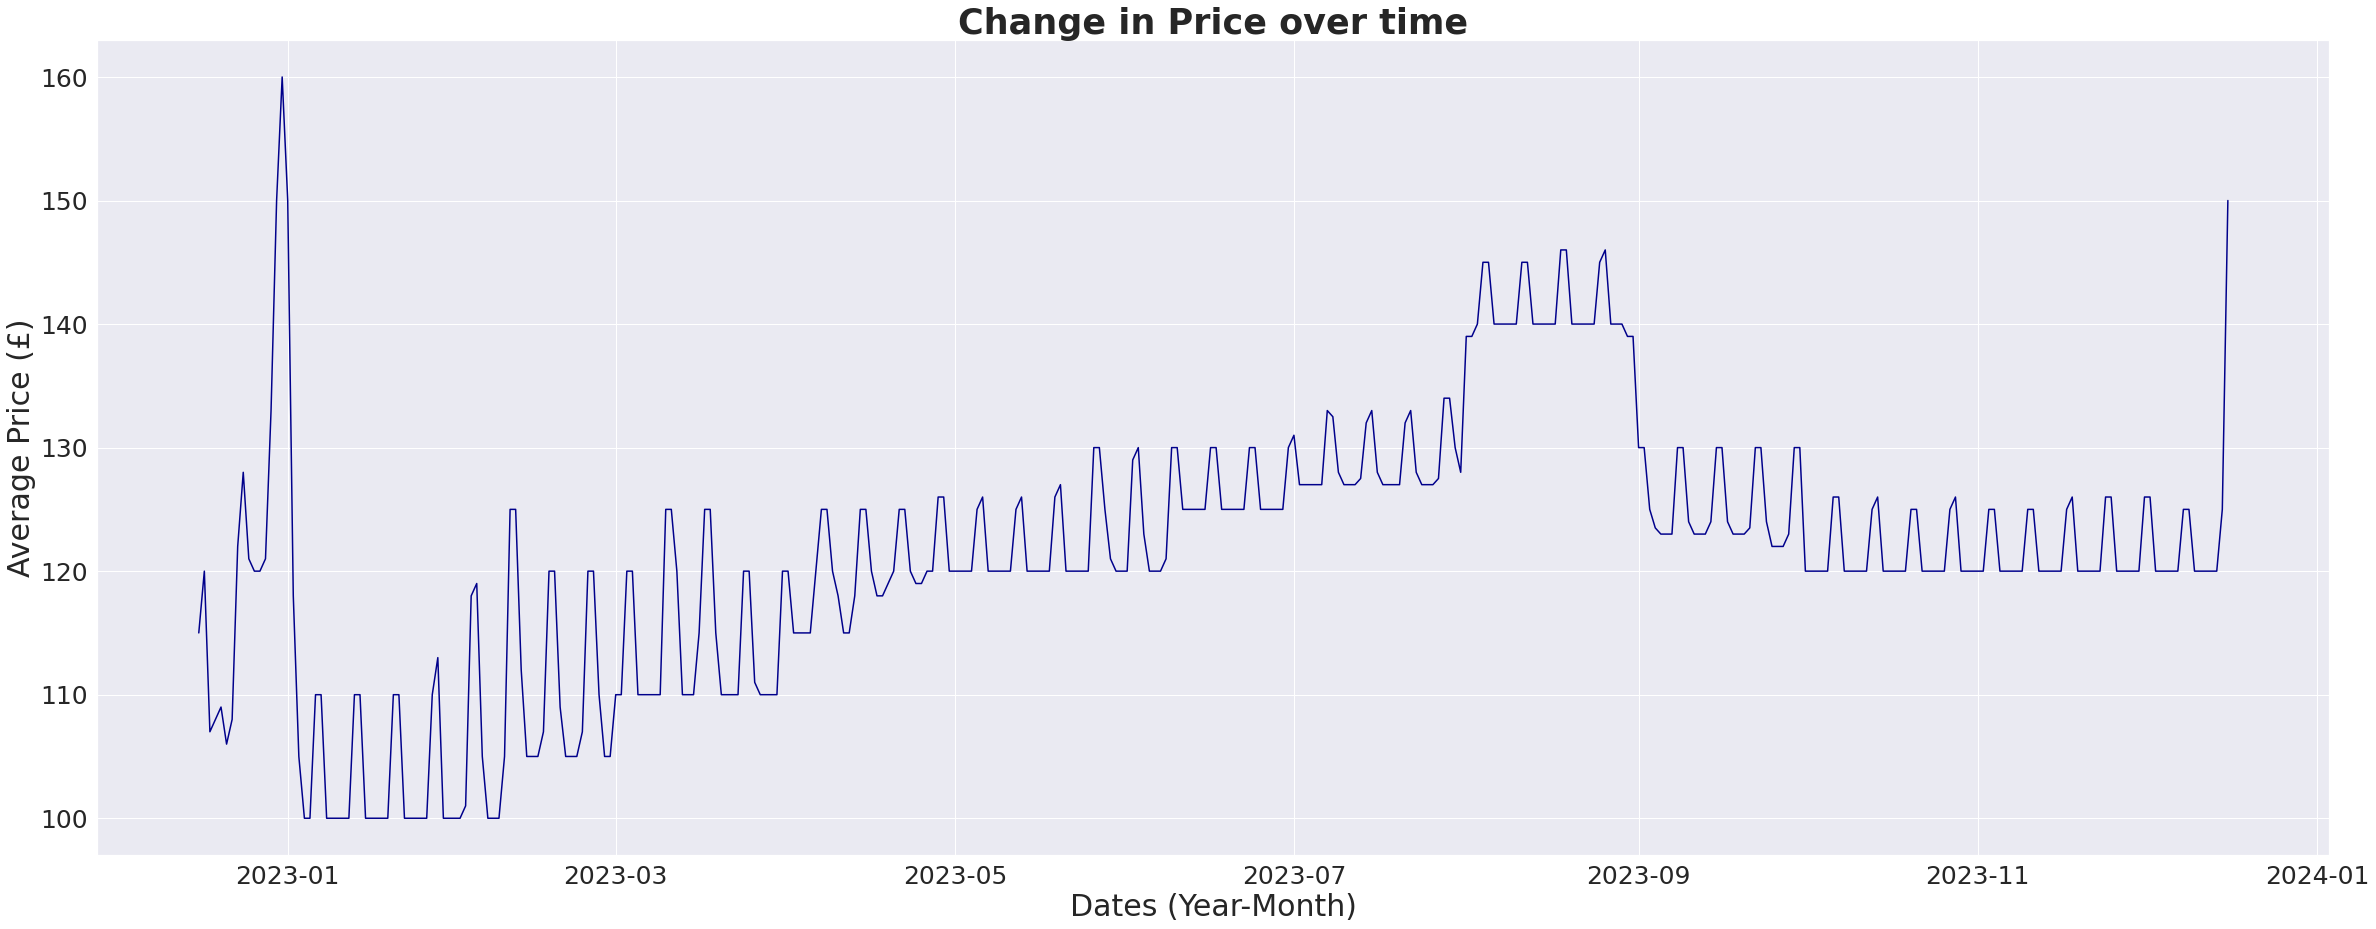

In [34]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import datetime as dt
sns.set_theme()
plt.figure(figsize = (40,15))


plt.plot(median_prices, color = 'darkblue')
plt.title('Change in Price over time', fontsize = 35, weight = 'bold')
plt.ylabel('Average Price (£)', fontsize = 30)
plt.xlabel('Dates (Year-Month)', fontsize = 30)

plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)

plt.show()

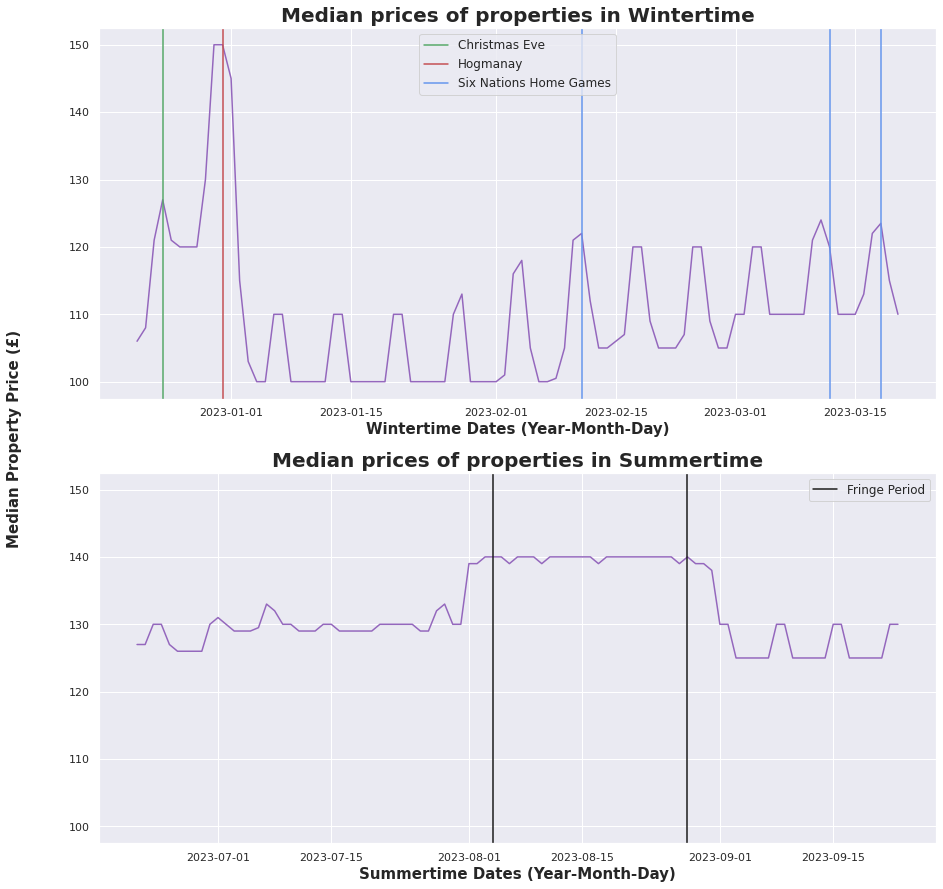

In [35]:
sns.set_theme()

fig, axs = plt.subplots(2,figsize=(15, 15), sharey = True)


axs[0].plot(median_prices_winter, 'tab:purple')
axs[1].plot(median_prices_summer, 'tab:purple')


axs[0].set_title('Median prices of properties in Wintertime', fontsize = 20, weight = 'bold')
axs[0].axvline(dt.datetime(2022, 12, 24), color = 'g', label = 'Christmas Eve')
axs[0].axvline(dt.datetime(2022, 12, 31), color = 'r', label = 'Hogmanay')
axs[0].axvline(dt.datetime(2023, 2, 11), color = 'cornflowerblue', label = 'Six Nations Home Games')
axs[0].axvline(dt.datetime(2023, 3, 12), color = 'cornflowerblue')
axs[0].axvline(dt.datetime(2023, 3, 18), color = 'cornflowerblue')
axs[0].set_xlabel('Wintertime Dates (Year-Month-Day)', fontsize = 15, weight = 'bold')


axs[1].set_title('Median prices of properties in Summertime', fontsize = 20, weight = 'bold')
axs[1].axvline(dt.datetime(2023, 8, 4), color = 'k', label = 'Fringe Period')
axs[1].axvline(dt.datetime(2023, 8, 28), color = 'k')
axs[1].set_xlabel('Summertime Dates (Year-Month-Day)', fontsize = 15, weight = 'bold')

axs[0].legend(fontsize = 12)
axs[1].legend(fontsize = 12)

fig.text(0.04, 0.5, 'Median Property Price (£)', va = 'center', rotation = 'vertical', fontsize = 15, weight = 'bold')

plt.savefig("Edinburgh_trends.png")

<h1>Cost of living/inflation impact on price of listings, Q4</h1>

In [36]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import datetime as dt

calendar = pd.read_csv('https://www.inf.ed.ac.uk/teaching/courses/fds/data/project-2022-2023/airbnb/calendar.csv.gz')
calendar["price"] = calendar["price"].replace('[$,]', '', regex=True).astype(float)


pricesPerc = calendar[['listing_id','date', 'price']]
pricesPerc['date'] = pd.to_datetime(pricesPerc['date'])
pricesPerc.groupby('date')

pricesPerc = prices.dropna()
pricesPerc = prices.reset_index(drop=True)

zeroentries = (pricesPerc == 0).any(axis=1)

pricesPerc = pricesPerc[~zeroentries]

print(pricesPerc.head)

d = {'listing_id': [-1], 'date':dt.datetime(2000, 12, 31), 'price': [-1], 'standard': [-1]}
standardPriceChange = pd.DataFrame(data=d)
 
for i in unique:
    individual = pricesPerc.loc[pricesPerc['listing_id'] == i]
    if individual.shape[0]>=1:
        priceList = individual['price'].tolist()
        startPrice = priceList[0]
        individual['standard'] = individual.apply(lambda row : (row[2]/startPrice)*100, axis=1)
        standardPriceChange = standardPriceChange.append(individual, ignore_index=True)
    print(i)
standardPriceChange = standardPriceChange[standardPriceChange.listing_id != -1]

KeyboardInterrupt: 

In [ ]:
import datetime as dt

mean_standard = standardPriceChange.groupby('date')['standard'].mean()

plt.figure(figsize = (40,15))


plt.plot(mean_standard, color = 'darkblue')
plt.title('Percent change in price over time', fontsize = 50, weight = 'bold')
plt.ylabel('Price percent change (%)', fontsize = 45, weight = 'bold')
plt.xlabel('Dates (Year-Month)', fontsize = 45, weight = 'bold')
plt.axhline(y=100, linestyle = 'dotted',color='red')
plt.xticks(fontsize = 35)
plt.yticks(fontsize = 35)

plt.savefig("Edinburgh_price_percentage_increase_mean.png")

plt.show()